In [1]:
import numpy as np
import os
import random
from sys import platform as sys_pf

import matplotlib
if sys_pf == 'darwin':
	matplotlib.use("TkAgg")

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf

from keras.models import Sequential, Model
from keras.models import load_model

from keras.applications.vgg16 import VGG16

from keras.layers import Flatten
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input

from keras.callbacks import History 

from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from sklearn.utils import shuffle

import h5py

Some utility functions 

In [2]:
def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I)
	return I
# convert to str and add leading zero to single digit numbers
def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

Practise loading a random image from our dataset

generating figure 1 of 1


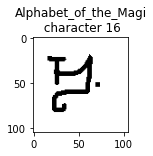

In [3]:
num_alphabets = 1
num_samples = 1
img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names

for a in range(num_alphabets): # for each alphabet
        print('generating figure ' + str(a+1) + ' of ' + str(num_alphabets))
        alpha_name = alphabet_names[a]
        
        # choose a random character from the alphabet
        character_id = random.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

        # get image directory for this character
        img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))


        # get base file name for this character
        fn_example = os.listdir(img_char_dir)[0]
        fn_base = fn_example[:fn_example.find('_')] 

        plt.figure(a,figsize=(10,8))
        plt.clf()
        for r in range(1,num_samples+1): # for each rendition
            plt.subplot(4,5,r)
            fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'			
            I = load_img(fn_img)
            np.set_printoptions(threshold=np.inf)
            plt.imshow(I, cmap='gray')
            if r==1:
                plt.title(alpha_name[:20] + '\n character ' + str(character_id))


more utility functions to load pixel data for each image in an alphabet and make pairs of images for training

In [4]:
def load_imgs(alphabet_names):
    X = np.array([])
    Y = np.array([])
    for alpha_name in alphabet_names:
        print('loading {} alphabet'.format(alpha_name))
        char_ids = range(1,len(os.listdir(os.path.join(img_dir,alpha_name))) + 1)
        # get image directory for this character
        for char_id in char_ids:
            img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(char_id))
            # get list of individual file names for each sample of a character
            img_fns = os.listdir(img_char_dir)
            # np arrays containing data of all samples of a character
            data = np.array([plt.imread(os.path.join(img_char_dir, fn)) for fn in img_fns])
            for i in range(len(img_fns)):
              Y = np.append(Y, alpha_name + '_character'+num2str(char_id)) # within alphabet discrimination
              # Y = np.append(Y, alpha_name) # between alphabet discrimination
            if X.size == 0:
                X = data
            else:
                X = np.vstack((X, data))

        
    return X, Y

def make_pairs(X, Y):

    pairs = []
    labels = []

    for i in range(len(X)):
        if i%1000 == 0:
            print(i)
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        J = [j for j, y in enumerate(Y) if y == class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [1]

        # get non-match
        # get possible indices where x2 is different from x1
        J = [j for j, y in enumerate(Y) if y != class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [0]
        
    return np.array(pairs), np.array(labels)



Use our utility function to get training set and test set

In [5]:
def get_train_test_data(n, alphabet_names):

    train_alphabets = alphabet_names[:n]
    test_alphabets = alphabet_names[n:]

    X_train, Y_train = load_imgs(train_alphabets)
    train_pairs, train_labels = make_pairs(X_train, Y_train)

    X_test, Y_test = load_imgs(test_alphabets)

    return train_pairs, train_labels, X_test, Y_test

In [6]:
def save_data(**kwargs):
    # save it once to allow load from file

    # train_pairs, train_labels and X_test all contain 0s and 1s which can be converted to unsigned 8 bit ints
    # use np.astype(np.uint8) to convert array before saving

    print('saving data...')
    for key, value in kwargs.items():

        with h5py.File('{}.h5'.format(key), 'w') as hf:

           if type(value).__module__ == np.__name__:

                # train_pairs and X_test are image sets which are just 0s and 1s
                # train_labels also contain only 0s and 1s which 
                # can be converted to unsigned 8 bit ints
                # use np.astype(np.uint8) to convert array before saving

                value = value.astype(np.uint8)
                hf.create_dataset(key, value.shape, h5py.h5t.STD_U8BE, data = value)
                print('saved {} as {}.h5!'.format(key, key))

           else:

                # Y_test is a list that contains np strings of class names 
                # np strings are not supported by h5 (save as normal python list of strings before saving)
                value = list(map(str, value))
                hf.create_dataset(key, data = value)
                print('saved {} as {}.h5!'.format(key, key))
            
    
    return None

In [20]:
save_data(train_pairs3=train_pairs3)

saving data...
saved train_pairs3 as train_pairs3.h5!


In [10]:
# train_a = alphabet_names[:20]
# test_a = alphabet_names[20:]
# X_train, Y_train = load_imgs(train_a)
# X_test, Y_test = load_imgs(test_a)
# save_data(Y_train=list(Y_train), X_test=X_test)

In [7]:
#load from file
def load_data(**kwargs):

    all_data = {}

    for key, value in kwargs.items():

        if value:

            with h5py.File('{}.h5'.format(key), 'r') as hf:

                if type(hf[key][0]) == bytes:
             
                    data = [item.decode('utf8') for item in hf[key][:]] # convert from bytes to str
                else:
                    data = hf[key][:]

                all_data.update({key : data}) 
                print('{} loaded from {}.h5!'.format(key, key))

    return all_data


Load our data and assign to variables

In [29]:
# resulting variable name as key, value is filename to load
kwargs = {'train_pairs' : True,
          'train_pairs3' : True,
          'train_labels' : True,
          'X_test' : True,
          'Y_test' : True,
          'X_test3' : True,
          'X_train' : True,
          'Y_train' : True
          }
data = load_data(**kwargs)


train_pairs loaded from train_pairs.h5!
train_pairs3 loaded from train_pairs3.h5!
train_labels loaded from train_labels.h5!
X_test loaded from X_test.h5!
Y_test loaded from Y_test.h5!
X_test3 loaded from X_test3.h5!
X_train loaded from X_train.h5!
Y_train loaded from Y_train.h5!


In [30]:

X_train = data['X_train']
Y_train = data['Y_train']

train_pairs = data['train_pairs']
train_pairs3 = data['train_pairs3']
train_labels = data['train_labels']

X_test = data['X_test']
X_test3 = data['X_test3']
Y_test = data['Y_test']







Visualise our data to see if pairs correspond to their labels

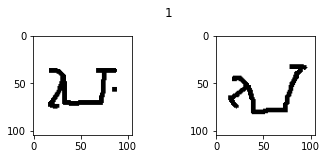

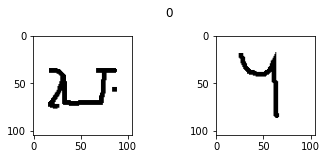

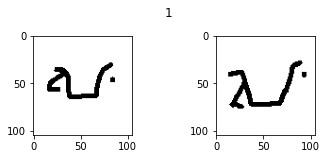

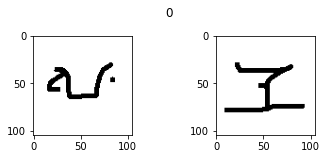

In [10]:
for i in range(4):
    
    fig = plt.figure()
    fig.suptitle(train_labels[i])
    plt.subplot(2,2,1)
    plt.imshow(train_pairs[i][0], cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(train_pairs[i][1], cmap='gray')

Callbacks to stop training our model when loss on validation set is increasing

In [11]:
BATCH_SIZE = 16

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, val_inputs, val_labels, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.val_inputs = val_inputs
        self.val_labels = val_labels

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_begin(self, epoch, logs=None):
        if epoch != 0:
            print('\n\n')

    def on_epoch_end(self, epoch, logs=None):
        
        print('\nEvaluating model on validations set')
        metrics = self.model.evaluate(x=self.val_inputs, y=self.val_labels, batch_size=BATCH_SIZE, verbose=1, sample_weight=None, steps=None, return_dict = True)
        current = metrics['loss']

        # for plotting learning process
        logs['epoch'] = epoch
        logs['val_loss'] = metrics['loss']
        logs['val_acc'] = metrics['accuracy']

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch + 1))

Create our model!

In [12]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network

    model = Sequential()
    
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                        kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), 
                        kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.1),
                    bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01)))
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net  

In [13]:
model = get_siamese_model((105,105,1))
optimizer = Adam(lr = 0.00009)
model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         20071232    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]             

split our training data into training and validation sets to keep track of overfitting using our custom callback

In [46]:
train_pairs, val_pairs, train_labels, val_labels = train_test_split(train_pairs, train_labels, test_size=0.1, random_state=42)
val_inputs = [val_pairs[:,0], val_pairs[:,1]]

print(train_pairs.shape, val_pairs.shape)

(22788, 2, 105, 105) (2532, 2, 105, 105)


train our model!

In [177]:
model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, batch_size=BATCH_SIZE, epochs=5, callbacks=[EarlyStoppingAtMinLoss(patience=1, val_inputs=val_inputs, val_labels=val_labels)])

Epoch 1/5
40/40 [==============================] - 27s 678ms/step - loss: 109.2916 - accuracy: 0.8641

Evaluating model on validations set
10/10 [==============================] - 2s 167ms/step - loss: 106.7843 - accuracy: 0.6875
Epoch 2/5



40/40 [==============================] - 28s 708ms/step - loss: 104.0428 - accuracy: 0.8859

Evaluating model on validations set
10/10 [==============================] - 2s 175ms/step - loss: 101.7077 - accuracy: 0.6875
Restoring model weights from the end of the best epoch.
Epoch 00002: early stopping


save our model!

In [ ]:
model.save('inset_fn.h5')

make a function to generate a random n-way-k-shot test (including query image and support set) to test our model

In [14]:
def get_test(X_test, Y_test, N, K):
    
    # get num_tests amount of queries and support sets (n way k shot)
    # final output is a list of lists of tuples. Each inner list is a test containing tuple pairs in the form: [(Q, s1), (Q, s2),..., (Q, sk)]
    # where Q is the query img and s1 to sk are k imgs of the support set
    # second output is a list of targets(answers)
    # init lists of queries and support sets

    support_set = []
    targets= np.zeros(N*K)
    test_classes = list(set(Y_test))
   
    # choose random index
    i = np.random.randint(0, len(X_test))

    # get query img and corresponding label
    query = X_test[i]
    label = Y_test[i]
    
    # get 1 * K pairs that is same class
    for k in range(K):
        pos_j = [j for j, class_ in enumerate(Y_test) if class_ == label]
        j = np.random.choice(pos_j)

        pair = [query, X_test[j]]
        targets[k] = 1
        support_set.append(pair)

    # get n-1 * K pairs that are of diff class
    test_classes.remove(label)

    support_classes = []
    for n in range(N-1):

        random_class = np.random.choice(test_classes)
        support_classes.append(random_class)        
    
        for k in range(K):
            
            pos_j = [j for j, class_ in enumerate(Y_test) if class_ == random_class]
            j = np.random.choice(pos_j)
            pair = [query, X_test[j]]
            support_set.append(pair)
            
        test_classes.remove(random_class)

   
    # shuffle support set and add to all support sets
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    

In [15]:
def get_alphabet_test(X_test, Y_test, test_alphabets):

    img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
    
    # choose random alphabet from test alphabets
    query_alphabet = np.random.choice(test_alphabets)

    # choose random char from all characters of alphabet, and get up to 19 other characters as support set
    num_chars = len(os.listdir(os.path.join(img_dir, query_alphabet)))
   
    # pick up to 20 in total of random characters
    N = min(20, num_chars)
    id_range = range(1,num_chars)
    pos_chars = np.random.choice(id_range, size=N)

    query_char = '_character{}'.format(num2str(pos_chars[0])) 

    # the label of the query image
    label = query_alphabet + query_char
    
    # init
    support_set = []
    targets = np.zeros(N)
    
    # choose query and support set pair image corresponding to the chosen label
    pos_i = [i for i, class_ in enumerate(Y_test) if class_ == label]
    i = np.random.choice(pos_i)
    query = X_test[i]
    
    pos_j = [j for j, class_ in enumerate(Y_test) if class_ == label]
    j = np.random.choice(pos_j)
    support_img = X_test[j]

    # add as first item of support set 
    support_set.append([query, support_img])
    targets[0] = 1

    # all available classes for the support set 
    support_classes = ['{}_character{}'.format(query_alphabet, num2str(i)) for i in pos_chars[1:]]

    # iterate through the list and add 1 random image from each class to support set (excluding the label)
    for item in support_classes:
        
        pos_j = [j for j, class_ in enumerate(Y_test) if class_ == item]
        j = np.random.choice(pos_j)
        pair = [query, X_test[j]]
        support_set.append(pair)
    
    # shuffle support set and targets 
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    
   

Testing the above function

(20, 2, 105, 105)


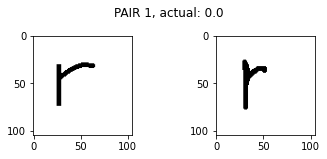

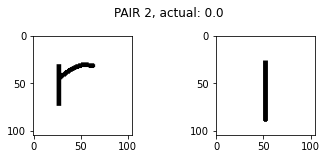

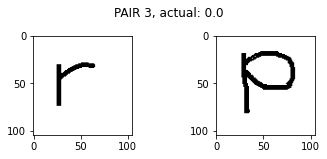

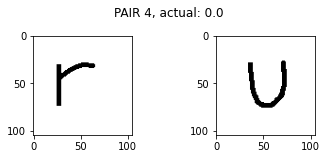

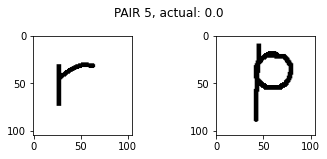

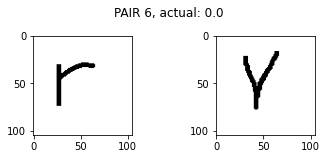

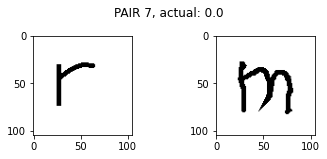

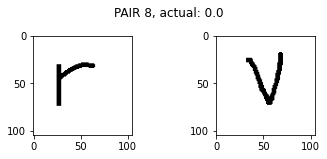

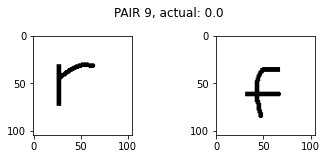

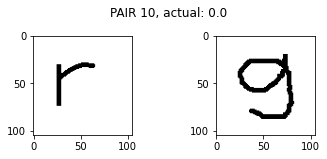

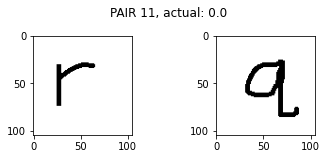

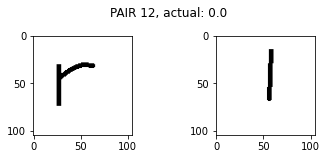

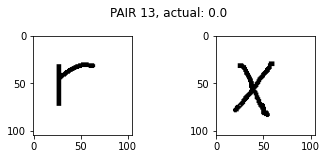

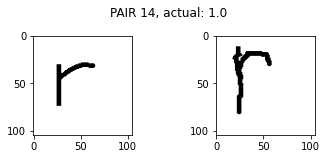

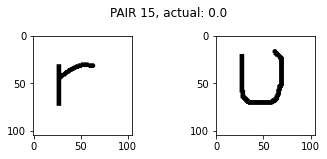

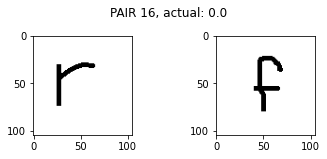

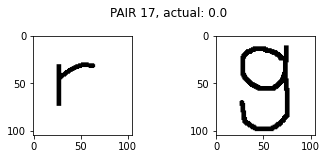

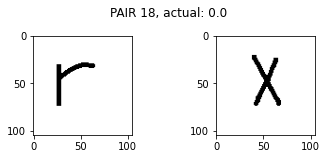

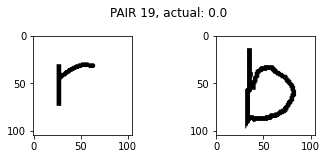

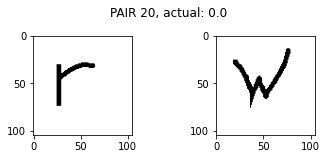

In [16]:
test_alphabets = alphabet_names[20:]

support_set20, targets20 = get_alphabet_test(X_test, Y_test, test_alphabets)
print(support_set20.shape)

for i in range(len(support_set20)):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax1.imshow(support_set20[i][0], cmap='gray')
    ax2 = fig.add_subplot(222)
    ax2.imshow(support_set20[i][1], cmap='gray')
    fig.suptitle('PAIR {}, actual: {}'.format( i+1, targets20[i]))

Create a model class for testing of our prototyped FSL models against some baselines (e.g random guess and nearest neighbour) for validation

In [17]:
class Predictor(object):

    def __init__(self, name):
        self.n_correct = 0
        self.num_tests = 0
        self.name = name
        self.prediction = None
        self.use_training_set = False
        self.only_supports_rgb = False
    
    def reset(self):
        self.n_correct = 0
        self.num_tests = 0
        self.prediction = None

    def get_name(self):
        return self.name

    def get_n_correct(self):
        return self.n_correct

    def get_num_tests(self):
        return self.num_tests

    def get_prediction(self):
        return self.prediction

    def set_prediction(self, support_set, targets):
        # to be overridden by subclasses
        self.prediction = 0

    def update_score(self, support_set, targets, verbose):
        self.set_prediction(support_set, targets)
        if targets[self.get_prediction()] == 1:
            self.n_correct += 1
        self.num_tests += 1

        if verbose and self.get_num_tests() < 10:
            print('TEST {}'.format(self.get_num_tests()))
            print('{} GUESSED PAIR {}'.format(self.get_name(), self.get_prediction() + 1))
    
            if targets[self.get_prediction()] == 1:
                print("CORRECT")
            else:
                print("INCORRECT")
            print('\n')

    def calc_accuracy(self, N, K):
        acc = round((self.n_correct/self.num_tests) * 100, 2)
        print("{} Model achieved {}% accuracy on {} {}-way {}-shot tests".format(self.get_name(), acc, self.get_num_tests(), N, K))
        return acc
   



In [18]:
class FSL(Predictor):

    def __init__(self, model, name='Few Shot Learning', use_training_set=False, only_supports_rgb=False):
        super().__init__(name)
        self.model = model
        self.name = name
        self.probs = None
        self.use_training_set = use_training_set
        self.only_supports_rgb = only_supports_rgb
        
    def get_probs(self):
        return np.round(self.probs, 4) 

    def set_prediction(self, support_set, targets):
        probs = self.model.predict([support_set[:,0], support_set[:,1]])
        self.probs = probs
        self.prediction = np.argmax(probs)
    
        

In [19]:
class Random(Predictor):

    def __init__(self, name = 'Random Guess'):
        super().__init__(name)
        self.name = name
       
   
    def set_prediction(self, support_set, targets):
        self.prediction = np.random.randint(0, len(support_set))
       


class Nearest_Neighbour(Predictor):

    def __init__(self, name ='Nearest Neighbour'):
        super().__init__(name)
        self.name = name
 
    def set_prediction(self, support_set, targets):
        # picks the class of image in the support set which has min L1 distance from query image
        min_dist = 10e9
        prediction = None
        for i in range(len(support_set)):
            pair = support_set[i]
            curr_dist = np.linalg.norm(pair[0].flatten() - pair[1].flatten(), ord=1)
            if curr_dist < min_dist:
                min_dist = curr_dist
                prediction = i
        self.prediction = prediction

In [20]:
def test_models(models, X_test, Y_test, num_tests, N, K, verbose = 0):
    """function to test any or all of our models that belong to the same Model class on the same test set of
    N way K shot cases over num_test tasks. Use verbose=1 setting to output prediciton data and create relevant visualisations!"""
    
    # limit number of graphs to be plotted for visualisation
    MAX_GRAPHS = 20
    CURR_GRAPHS = 0

    if verbose:
        print("Evaluating models on {} random {} way {} shot learning tasks ... \n".format(num_tests, N, K))


    for num in range(num_tests):
        
        support_set, targets = get_test(X_test, Y_test, N, K)

        for model in models:
            
            copy_support_set = support_set[:]
            copy_targets = targets[:]

            if model.use_training_set:
                # 'Test' this model on the training set (for comparison purposes)
                copy_support_set, copy_targets = get_test(X_train, Y_train, N, K)
        
            if model.only_supports_rgb:
                # Convert 1 channel images to 3 channel for prediction
                copy_support_set3=np.zeros(copy_support_set.shape +(3,))

                for i in range(len(copy_support_set)):
                    for j in range(2):
                        img = np.stack((copy_support_set[i][j],)*3, axis=-1)
                        copy_support_set3[i][j] = img

                copy_support_set = copy_support_set3

            model.update_score(copy_support_set, copy_targets, verbose)

            
           

            if isinstance(model, type(FSL(model))) and verbose and CURR_GRAPHS <= MAX_GRAPHS:

                for i in range(len(support_set)):
        
                    fig = plt.figure()
                    ax1 = fig.add_subplot(221)
                    ax1.imshow(support_set[i][0], cmap='gray')
                    ax2 = fig.add_subplot(222)
                    ax2.imshow(support_set[i][1], cmap='gray')
                    fig.suptitle('TEST {}, PAIR {}\n{}: {}, actual: {}'.format(num + 1, i+1, model.name, model.get_probs()[i], targets[i]))

                    CURR_GRAPHS += 1

    accuracy = {}
    for model in models:
        accuracy.update({model.name : model.calc_accuracy(N, K)})
    return accuracy

In [57]:
def get_accuracy(models, N, num_tests):
    '''tests various model(s)/baseline(s) using num_tests amount of n-way 1-shot tasks (n belongs to N)
    and output their mean accuracies over all tests for each n in N'''

    # init 
    accuracies = {name : [] for name in [model.name for model in models]}
    accuracies.update({'range_' : N})
    for n in N:

        if n == 1:
            for k, v in accuracies.items():
                if k != 'range_':
                    accuracies[k].append(100)
            continue

        accuracy = test_models(models, X_test, Y_test, num_tests, n, K=1, verbose = 0)

        # reset attributes of models
        for model in models:
            model.reset()

        for k, v in accuracy.items():
            accuracies[k].append(v)

    return accuracies

def plot_accuracy(accuracies, save=None):
    
    plt.figure()

    N = accuracies['range_']
    for k, v in accuracies.items():

        # ignore the range entry (they are the x values)
        if k != 'range_':
            plt.plot(N, v, label=k)

    # Set the axes labels and fix x axise intervals
    plt.xlabel('# of Classes')
    plt.xticks(N)
    plt.xlim(N[0], N[-1]+1)
    
    plt.ylabel('Model Accuracy (%)')

    # Set title of the current axes.
    plt.title('Prediction Accuracy vs # of Classes in 1-Shot Support Set')

    # show legend on the plot
    plt.legend()

    if save:
        plt.savefig(save)
        print("Graph was saved as {}!".format(save))

    # Display the figure.
    plt.show()


We can now get the accuracies of any combination of models of our choosing over a set number of tests, and plot them!

In [24]:
# Our siamese network that we trained on the training dataset only
scratch_model = load_model('model_8.h5')

# Siamese net that was pretrained on large scale dataset and fine tuned with our trainng datset
fine_tuned_model = load_model('vgg16')

# Same as above, except it was not fine tuned to our training set
pretrained_model = get_pretrained_model((105,105,3))

optimizer = Adam(lr = 0.00009)
pretrained_model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 4608)         14714688    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4608)         0           Embedding[0][0]            

In [53]:
model = load_model('vgg16_callback')

In [54]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 4608)         14714688    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4608)         0           Embedding[0][0]            

In [58]:
N = range(1, 11)
NUM_TESTS = 1000
# models = [
#          FSL(scratch_model), 
#          FSL(scratch_model, name='Few Shot Learning (Training)', use_training_set=True)], 
#          FSL(pretrain_model, name='Few Shot Learning (Pretrained)', only_supports_rgb=True),
#          FSL(pretrain_model, name='FSL (Pretrained) (Training)', use_training_set=True, only_supports_rgb=True) 
#          Random(), 
#          Nearest_Neighbour(),
#          FSL(model, only_supports_rgb=True, name='CNN Nearest Neighbour') 
#          ]
# accuracies = get_accuracy(models, N, NUM_TESTS)
accuracies = get_accuracy([FSL(model, name='FSL (Pretrained) (Early Stop)', use_training_set=True, only_supports_rgb=True)], N, NUM_TESTS)
print(accuracies)

FSL (Pretrained) (Early Stop) Model achieved 99.5% accuracy on 1000 2-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 97.9% accuracy on 1000 3-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 96.5% accuracy on 1000 4-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 96.5% accuracy on 1000 5-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 95.9% accuracy on 1000 6-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 95.5% accuracy on 1000 7-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 94.9% accuracy on 1000 8-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 94.3% accuracy on 1000 9-way 1-shot tests
FSL (Pretrained) (Early Stop) Model achieved 91.7% accuracy on 1000 10-way 1-shot tests
{'FSL (Pretrained) (Early Stop)': [100, 99.5, 97.9, 96.5, 96.5, 95.9, 95.5, 94.9, 94.3, 91.7], 'range_': range(1, 11)}


Graph was saved as acc_early_stop.pdf!


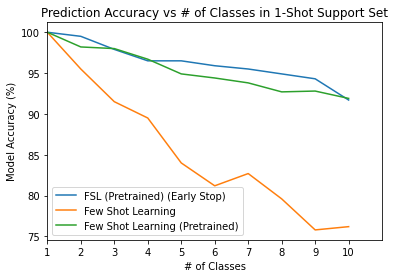

In [62]:
with open('accuracies_190421.txt', 'r') as f:
    contents = f.read()
    accuracies = eval(contents)
del accuracies['CNN Nearest Neighbour']
del accuracies['Few Shot Learning (Training)']
del accuracies['FSL (Pretrained) (Training)']
del accuracies['Random Guess Model']
del accuracies['Nearest Neighbour Model']
# plot_accuracy(accuracies, save='acc_pretrain_vs_ft.pdf')
plot_accuracy(accuracies, save='acc_early_stop.pdf')


In [23]:
def get_pretrained_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    pre_train = Sequential()
    base = VGG16(include_top=False, input_shape=input_shape)

    # freeze all layers but last 4
    for layer in base.layers[:-4]:
        layer.trainable = False
    
    pre_train.add(base)
    pre_train.add(tf.keras.layers.Flatten())
    embedding = Model(pre_train.input, pre_train.output, name="Embedding")
    
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = embedding(left_input)
    encoded_r = embedding(right_input)
    
 
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
  

    # # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)


    # # Connect the inputs with the outputs
    pretrained_model = Model(inputs=[left_input,right_input], outputs=prediction)

    # return the model
    return pretrained_model


In [31]:
train_pairs3, val_pairs3, train_labels, val_labels = train_test_split(train_pairs3, train_labels, test_size=0.1, random_state=42)
val_inputs = [val_pairs3[:,0], val_pairs3[:,1]]
train_test_split
print(train_pairs3.shape, val_pairs3.shape)

(22788, 2, 105, 105, 3) (2532, 2, 105, 105, 3)


either continue training a previously saved model or start from scratch

In [45]:
model = load_model('vgg16')

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_185 (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_186 (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 4608)         14714688    input_185[0][0]                  
                                                                 input_186[0][0]                  
__________________________________________________________________________________________________
lambda_44 (Lambda)              (None, 4608)         0           Embedding[0][0]           

In [46]:
model = get_pretrained_model((105,105,3))


In [47]:
optimizer = Adam(lr = 0.00009)
model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 4608)         14714688    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4608)         0           Embedding[0][0]            

In [48]:
# for plotting metrics of our model's learning process
hist = History()

model.fit([train_pairs3[:,0], train_pairs3[:,1]], train_labels, batch_size=64, epochs=10, callbacks=[EarlyStoppingAtMinLoss(patience=1, val_inputs=val_inputs, val_labels=val_labels), hist])

Epoch 1/10
357/357 [==============================] - 971s 3s/step - loss: 0.3602 - accuracy: 0.8419

Evaluating model on validations set
159/159 [==============================] - 86s 536ms/step - loss: 0.1712 - accuracy: 0.9427
Epoch 2/10



357/357 [==============================] - 977s 3s/step - loss: 0.1006 - accuracy: 0.9739

Evaluating model on validations set
159/159 [==============================] - 86s 540ms/step - loss: 0.1620 - accuracy: 0.9487
Epoch 3/10



357/357 [==============================] - 972s 3s/step - loss: 0.0540 - accuracy: 0.9904

Evaluating model on validations set
159/159 [==============================] - 86s 538ms/step - loss: 0.1473 - accuracy: 0.9573
Epoch 4/10



357/357 [==============================] - 963s 3s/step - loss: 0.0348 - accuracy: 0.9956

Evaluating model on validations set
159/159 [==============================] - 84s 531ms/step - loss: 0.1420 - accuracy: 0.9585
Epoch 5/10



357/357 [==============================] - 961s 3s/step -

We can visualise the learning curve of our trained model
see https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance for details

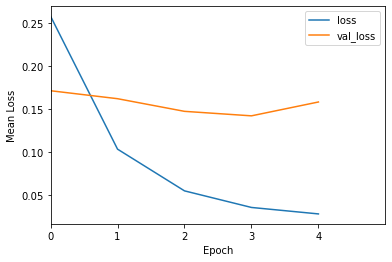

In [52]:
plt.figure()
X = hist.history['epoch']
for k, v in hist.history.items():
    if k != 'epoch' and 'loss' in k:
        plt.plot(X, v, label=k)

plt.xlabel('Epoch')
plt.xticks(X)
plt.xlim(X[0], X[-1]+1)

plt.ylabel('Mean Loss')
plt.legend()
plt.savefig('Learning Curve vgg16.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

In [50]:
model.save('vgg16_callback')

INFO:tensorflow:Assets written to: vgg16_callback\assets
